# My Novelty

Load YTB-001, YTB-005, YTB-013 Head IN segments, display audio players, and compute novelty functions.

In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import AUDIO_MARKERS_DIR, RAW_AUDIO_DIR
from dijon.novelty import (
    compute_novelty_complex,
    compute_novelty_energy,
    compute_novelty_phase,
    compute_novelty_spectrum,
)
from dijon.notebook_ui import display_audio_with_cursor

%matplotlib inline

In [2]:
def load_head_in(track: str):
    """Load HEAD_IN segment for a track. Returns (x, sr)."""
    marker_prefix = "HEAD_IN"
    audio_path = RAW_AUDIO_DIR / f"{track}.wav"
    x_full, sr = librosa.load(audio_path, sr=None, mono=True)
    markers_path = AUDIO_MARKERS_DIR / f"{track}_markers.json"
    with open(markers_path) as f:
        markers_data = json.load(f)
    markers = markers_data["entries"][0]["markers"]
    seg_start = next(m["position"] for m in markers if m["name"] == f"{marker_prefix}_START")
    seg_end = next(m["position"] for m in markers if m["name"] == f"{marker_prefix}_END")
    start_sample = int(seg_start * sr)
    end_sample = int(seg_end * sr)
    return x_full[start_sample:end_sample], sr

tracks = ["YTB-001", "YTB-005", "YTB-013"]
data = {t: load_head_in(t) for t in tracks}
for t in tracks:
    x, sr = data[t]
    print(f"{t} Head IN: {len(x)/sr:.2f}s @ {sr} Hz")

YTB-001 Head IN: 37.90s @ 22050 Hz
YTB-005 Head IN: 31.55s @ 22050 Hz
YTB-013 Head IN: 31.08s @ 22050 Hz


**YTB-001 Head IN**



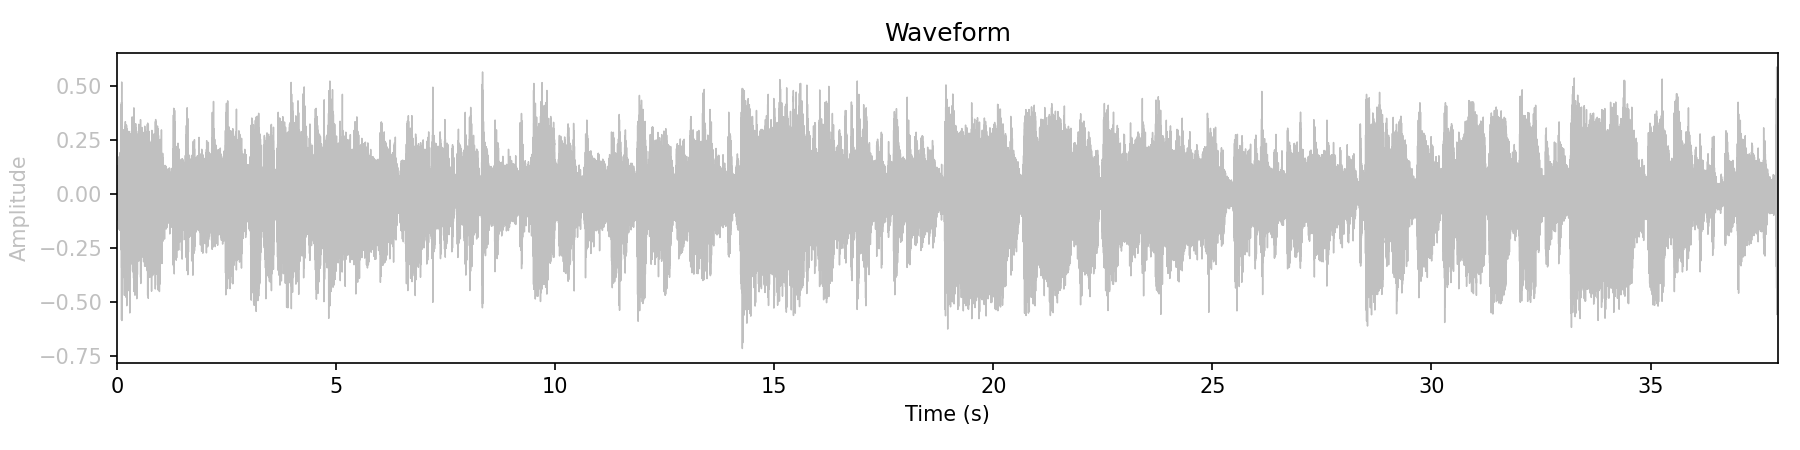

**YTB-005 Head IN**



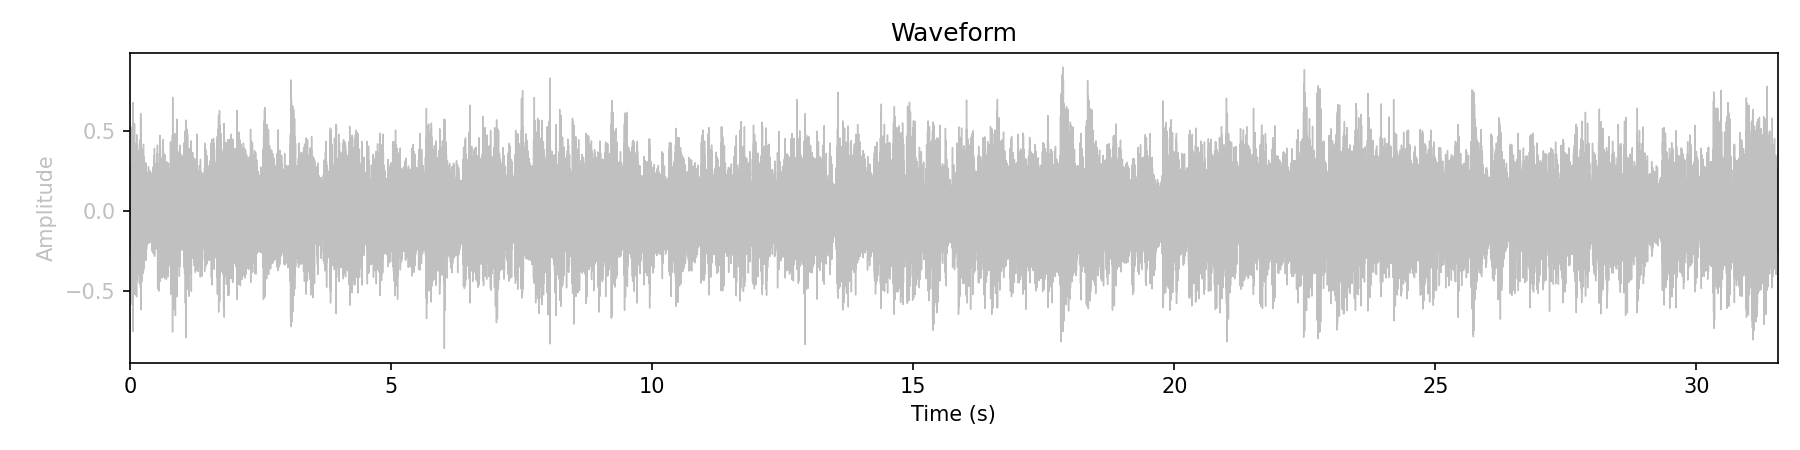

**YTB-013 Head IN**



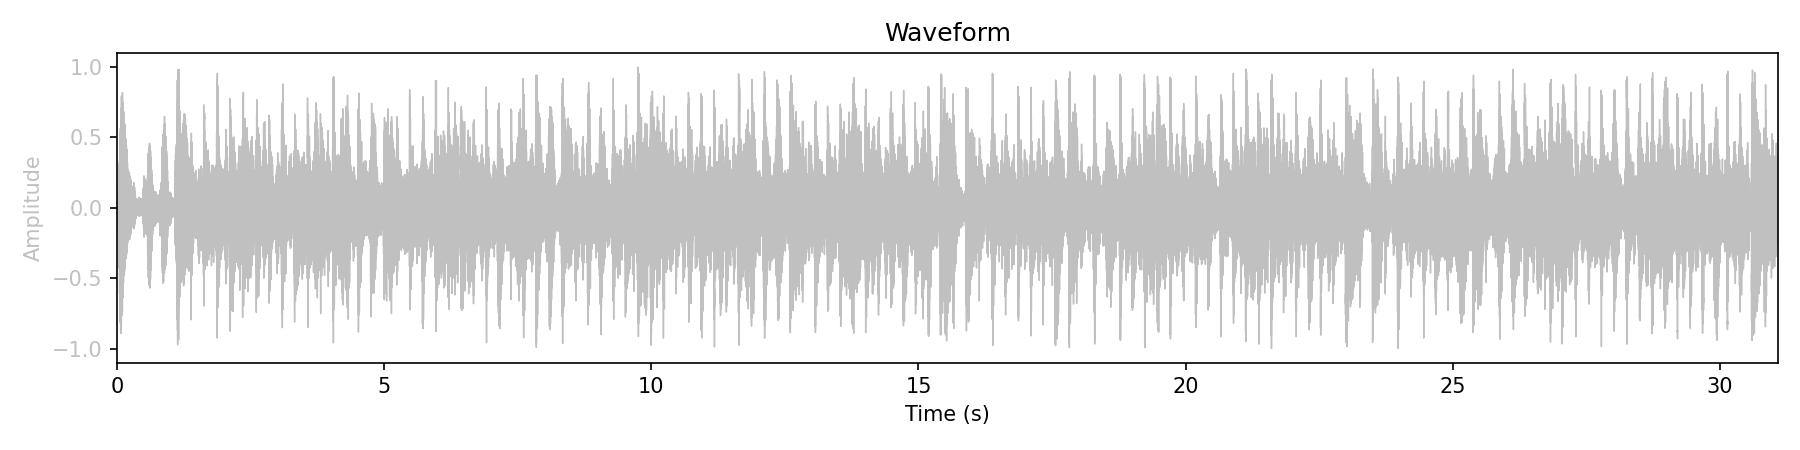

In [3]:
# Audio players for each track
for track in tracks:
    x, sr = data[track]
    print(f"**{track} Head IN**")
    display_audio_with_cursor(x, sr)

Type: phase  |  N: 1024  |  H: 64  |  gamma: 40  |  M: 10


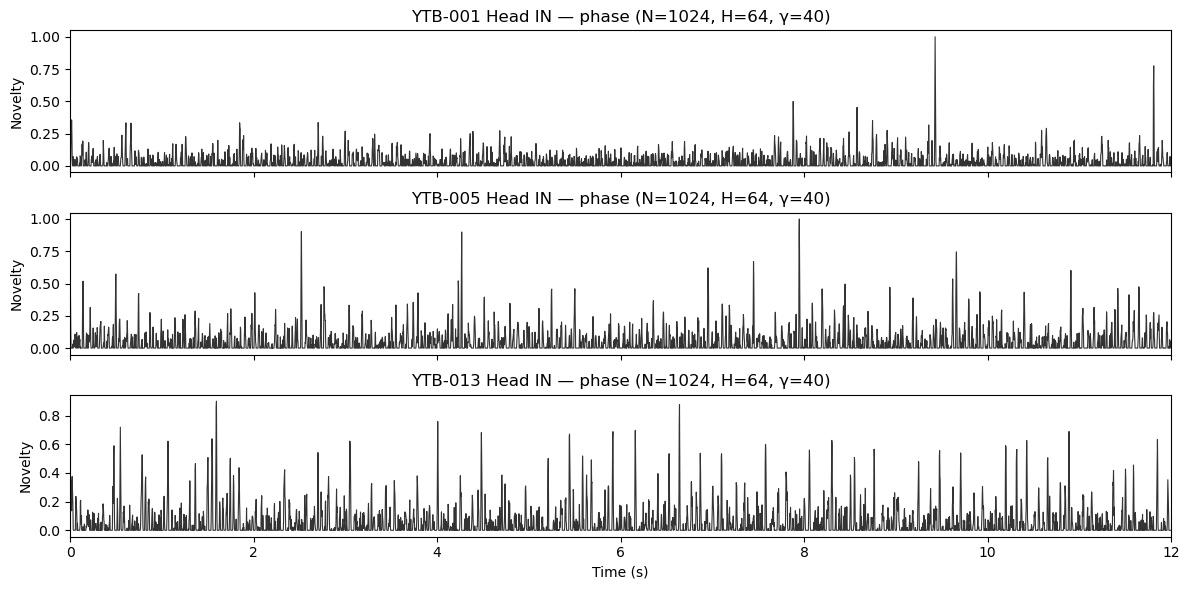

In [ ]:
# Novelty parameters (easy to edit)
# Suggested Default Parameters for each novelty type: (N, H, gamma, M)
# spectrum: 1024, 256, 100.0, 10
# energy: 2048, 512, 10.0, 0
# phase: 1024, 64, 40, 10
# complex: 1024, 64, 10.0, 40
NOVELTY_TYPE = "spectrum"
N = 1024
H = 256
gamma = 100.0
M = 10

print(f"Type: {NOVELTY_TYPE}  |  N: {N}  |  H: {H}  |  gamma: {gamma}  |  M: {M}")
def compute_novelty(x, sr, nov_type, N, H, gamma, M):
    """Dispatch to the correct novelty function."""
    if nov_type == "energy":
        return compute_novelty_energy(x, Fs=sr, N=N, H=H, gamma=gamma)
    if nov_type == "spectrum":
        return compute_novelty_spectrum(x, Fs=sr, N=N, H=H, gamma=gamma, M=M)
    if nov_type == "phase":
        return compute_novelty_phase(x, Fs=sr, N=N, H=H, M=M)
    if nov_type == "complex":
        return compute_novelty_complex(x, Fs=sr, N=N, H=H, gamma=gamma, M=M)
    raise ValueError(f"Unknown type: {nov_type}")

novelty_results = {}
for track in tracks:
    x, sr = data[track]
    nov, Fs_feat = compute_novelty(x, sr, NOVELTY_TYPE, N, H, gamma, M)
    novelty_results[track] = (nov, Fs_feat)
# Display first 12 seconds of novelty function for each track
DISPLAY_SEC = 12

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for i, track in enumerate(tracks):
    nov, Fs_feat = novelty_results[track]
    n_frames_12s = int(DISPLAY_SEC * Fs_feat)
    nov_12s = nov[:n_frames_12s]
    t_nov = np.arange(len(nov_12s)) / Fs_feat
    axes[i].plot(t_nov, nov_12s, color="#333", linewidth=0.8)
    axes[i].set_ylabel("Novelty")
    axes[i].set_title(f"{track} Head IN — {NOVELTY_TYPE} (N={N}, H={H}, γ={gamma})")
    axes[i].set_xlim(0, DISPLAY_SEC)
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()